In [ ]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/UvA SSO group 2/AFC/Project

Mounted at /content/drive
/content/drive/MyDrive/UvA SSO group 2/AFC/Project


In [ ]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import time, sys
from fbprophet import Prophet
from tqdm import tqdm, tnrange
from multiprocessing import Pool, cpu_count
from functools import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from datetime import datetime
import plotly.graph_objects as go
from scipy import stats 

try:
    import calmap
except:
    ! pip install calmap
    import calmap
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

future_preds = 28
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_calendar = pd.read_csv("../input/kaggle-afc/calendar_afcs2020.csv")
df_train =  pd.read_csv("../input/kaggle-afc/sales_train_validation_afcs2020.csv",index_col=0)
evaluation = pd.read_csv("../input/kaggle-afc/sales_train_evaluation_afcs2020.csv")
df_train.index = df_train.index.str.replace('_validation', '')
submission = pd.read_csv("../input/kaggle-afc/sample_submission_afcs2020.csv")
day_cols = pd.Series([c for c in df_train.columns if c.find('d_')==0])
def clean_data(df_train, day_cols, indx):
    t = df_train.loc[indx].copy()
    t.loc[day_cols[((t.loc[day_cols]>0).cumsum()==0).values]] = np.nan

    q1 = t.loc[day_cols].quantile(0.25)
    q3 = t.loc[day_cols].quantile(0.75)
    iqr = q3-q1
    qm = (q3+1.5*iqr)
    t.loc[day_cols][t.loc[day_cols]>qm] = qm
    return t
df_calendar.index = df_calendar['d'].values
df_calendar['ds'] = pd.to_datetime(df_calendar['date'])
df_calendar['quarter'] = df_calendar['ds'].dt.quarter
events1 = pd.Series(df_calendar['event_name_1'].values, index=df_calendar['ds'].values).dropna()
events2 = pd.Series(df_calendar['event_name_2'].values, index=df_calendar['ds'].values).dropna()
holidays = pd.DataFrame(pd.concat([events1, events2], axis=0))
holidays['ds'] = holidays.index.values
holidays.rename({0: 'holiday'}, axis=1, inplace=True)
holidays.reset_index(drop=True, inplace=True)
del events1, events2
data = [clean_data(df_train, day_cols, i) for i in df_train.index]
df_train = pd.concat(data, axis=1).T
df_sell_prices = pd.read_csv("../input/kaggle-afc/sell_prices_afcs2020.csv")

df_sell_prices['id'] = df_sell_prices['item_id'] + '_' + df_sell_prices['store_id']

df_sell_prices = df_sell_prices.pivot(index='id', columns='wm_yr_wk', values='sell_price')
df_sell_prices = df_sell_prices.fillna(method='bfill', axis=1)
df_prices = pd.DataFrame(index=df_train.index.values)
df_prices = list()
for i in df_sell_prices.columns:
    cols = df_calendar['d'][df_calendar['wm_yr_wk']==i]
    t = pd.concat([df_sell_prices[i] for j in cols], axis=1)
    t.columns = cols
    df_prices.append(t)
df_prices = pd.concat(df_prices, axis=1)
def make_prediction(indx):
    global df_train, holidays, df_prices, df_calendar
    changepoints=list()
    uncertainty_samples=False
    changepoint_prior_scale=0.1
    changepoint_range=0.9
    holidays_prior_scale=10
    yearly_seasonality=2
    weekly_seasonality=1
    daily_seasonality=False
    monthly_fourier_order=None
    quarter_fourier_order=None
    seasonality_prior_scale=10
    seasonality_mode = 'additive'
    
    target = df_train.loc[indx, day_cols]

    df = df_calendar.iloc[:target.shape[0]+future_preds][['ds', 'month', 'wday', 'quarter']]
    df['y'] = target
    df['prices'] = df_prices.loc[indx].iloc[:df.shape[0]].values

    m = Prophet(growth='linear', uncertainty_samples=uncertainty_samples, changepoint_prior_scale=changepoint_prior_scale, changepoint_range=changepoint_range,
                holidays_prior_scale=holidays_prior_scale, yearly_seasonality=yearly_seasonality,
                daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality,
                holidays=holidays, seasonality_mode=seasonality_mode, seasonality_prior_scale=seasonality_prior_scale)

    if not monthly_fourier_order is None:
        m.add_seasonality(name='monthly', period=365.25/12, fourier_order=monthly_fourier_order)
    if not quarter_fourier_order is None:
        m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=quarter_fourier_order)#, prior_scale=15)

    for reg in df.columns:
        if reg!='ds' and reg!='y':
            m.add_regressor(reg)
    m.fit(df.loc[target.loc[target.first_valid_index():].index])

    df.drop(['y'], axis=1, inplace=True)
    
    forecast = m.predict(df.iloc[-future_preds:])
    res = forecast['yhat']
    res.index = df.iloc[-future_preds:].index.values
    
    return res
submission = pd.read_csv("../input/kaggle-afc/sample_submission_afcs2020.csv", index_col=0)
start_time = time.time()
pool = Pool()

train_indxs = df_train.index
res = pool.map(make_prediction, train_indxs)
pool.close()
pool.join()
end_time = time.time()
for j, i in enumerate(train_indxs):
    submission.loc[i+'_validation'] = res[j].values
submission[submission<0]=0
submission.to_csv('submission123.csv')



In [ ]:
CAL_DTYPES={"event_name_1": "category", 
            "event_name_2": "category", 
            "event_type_1": "category", 
            "event_type_2": "category", 
            "weekday": "category", 
            'wm_yr_wk': 'int16', 
            "wday": "int16",
            "month": "int16", 
            "year": "int16", 
            "snap_CA": "float32"}
            
PRICE_DTYPES = {"store_id": "category", 
                "item_id": "category", 
                "wm_yr_wk": "int16",
                "sell_price":"float32" }
def create_calendar_df():
    calendar_df = pd.read_csv("../input/kaggle-afc/calendar_afcs2020.csv", dtype = CAL_DTYPES)
    calendar_df["date"] = pd.to_datetime(calendar_df["date"])
    return calendar_df
def create_prices_df():
    prices_df = pd.read_csv("../input/kaggle-afc/sell_prices_afcs2020.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices_df[col] = prices_df[col].cat.codes.astype("int16")
            prices_df[col] -= prices_df[col].min()
    prices_df['id2'] = prices_df['item_id']
    return prices_df
def create_dt(is_train = True, nrows = None, first_day = 1200):
    start_day = max(1 if is_train else tr_last - max_lags, first_day)
    numeric_cols = [f"d_{day}" for day in range(start_day, tr_last + 1)]
    category_cols = ['id']
    dtype = {numcol:"float32" for numcol in numeric_cols} 
    dtype.update({col: "category" for col in category_cols if col != "id"})
    sales_df = pd.read_csv("../input/kaggle-afc/sales_train_evaluation_afcs2020.csv", 
                     nrows = nrows, usecols = category_cols + numeric_cols, dtype = dtype)
    for col in category_cols:
        if col != "id":
            sales_df[col] = sales_df[col].cat.codes.astype("int16")
            sales_df[col] -= sales_df[col].min()
    if not is_train:
        for day in range(tr_last + 1, tr_last + h +1):
            sales_df[f"d_{day}"] = np.nan
    sales_df = pd.melt(sales_df,
                  id_vars = category_cols,
                  value_vars = [col for col in sales_df.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    calendar_df = create_calendar_df()
    prices_df = create_prices_df()
    sales_df = sales_df.merge(calendar_df, on= "d", copy = False)
    sales_df['id2'] = sales_df['id'].astype(str).str[:13]
    sales_df['id2'] = sales_df['id2'].astype("category")
    sales_df['id2'] = sales_df['id2'].cat.codes.astype("int16")
    sales_df = sales_df.merge(prices_df, on = ["id2"], copy = False)
    sales_df['item_id'] = sales_df['id2']
    sales_df.pop('id2')
    return sales_df
h = 28 
max_lags = 57
tr_last = 1913 + 28
FIRST_DAY = 350
fday = datetime(2016,4, 25) + timedelta(days= 28)
fday,tr_last,max_lags
df = create_dt(is_train=True, first_day= FIRST_DAY)
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",

    }
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
create_fea(df)
df.shape
df.dropna(inplace = True)
cat = ['store_id','item_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
no = ["id","date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(no)]
X_train = df[train_cols]
y_train = df["sales"]
np.random.seed(200)
test_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
test = np.setdiff1d(X_train.index.values, test)
train_data = lgb.Dataset(X_train.loc[test] , label = y_train.loc[train_inds], categorical_feature=cat, free_raw_data=False)
vali = lgb.Dataset(X_train.loc[test], label = y_train.loc[test],categorical_feature=cat,free_raw_data=False)
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 160,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}
m_lgb = lgb.train(params, train_data, valid_sets = [test], verbose_eval=20) 
def create_lag_features_for_test(dt, day):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt.loc[dt.date == day, lag_col] = \
            dt.loc[dt.date ==day-timedelta(days=lag), 'sales'].values  
    windows = [7, 28]
    for window in windows:
        for lag in lags:
            df_window = dt[(dt.date <= day-timedelta(days=lag)) & (dt.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(dt.loc[dt.date==day,'id'])
            dt.loc[dt.date == day,f"rmean_{lag}_{window}"] = \
                df_window_grouped.sales.values
def create_date_features_for_test(dt):
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(
                dt["date"].dt, date_feat_func).astype("int16")

In [ ]:
from itertools import product
def my_product(inp):
    return [dict(zip(inp.keys(), values)) for values in product(*inp.values())]
pattern = {
    'trend': [None, 'add'],
    'seasonal': [None, 'add'],
}
params = my_product(pattern)
calendar = pd.read_csv('../input/kaggle-afc/calendar_afcs2020.csv', parse_dates=['date'])
def read_sales(filename):
    sales = pd.read_csv(filename)
    sales.set_index('id', inplace=True)
    sales.columns = calendar.date[:len(sales.columns)]
    return sales
sales = read_sales('../input/kaggle-afc/sales_train_validation_afcs2020.csv')
#metric = 'aic'
#metric = 'aicc'
metric = 'bic'
def fit_es(data):
    data_id, data = data
    first_index = data[data > 0].index[0]
    data = data.loc[first_index:]
    best_score = np.inf
    best_model = None
    for param in params:
        fit = ExponentialSmoothing(data, seasonal_periods=7, initialization_method='estimated', freq='D', **param).fit()
        if metric == 'aic':
            if best_score > fit.aic:
                best_score = fit.aic
                best_model = fit
        elif metric == 'aicc':
            if best_score > fit.aicc:
                best_score = fit.aicc
                best_model = fit
        elif metric == 'bic':
            if best_score > fit.bic:
                best_score = fit.bic
                best_model = fit
        else:
            raise NotImplemntedError()
    fc = best_model.forecast(28)
    fc = pd.DataFrame([f])
    fc.columns = [f'F{i+1}' for i in range(28)]
    fc.insert(0, 'id', data_id)
    print (best_model.params)
    return fc
def forecast(sales):
    sales_list = list(sales.iterrows())
    pool = Pool(4)
    result = pool.map(fit_es, sales_list)
    return pd.concat(result)
sub = forecast(sales)

In [ ]:
cal = pd.read_csv('calendar_afcs2020.csv')
sp = pd.read_csv('sell_prices_afcs2020.csv')
stv = pd.read_csv('sales_train_validation_afcs2020.csv')
calendar= cal

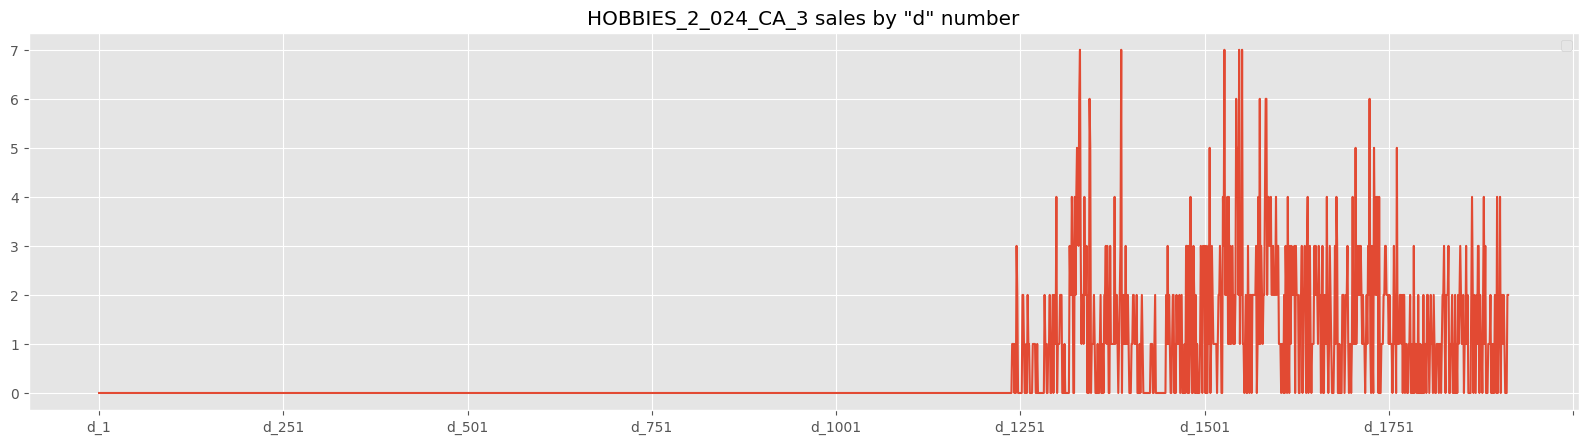

In [ ]:

d_cols = [c for c in stv.columns if 'd_' in c]

stv.loc[stv['id'] == 'HOBBIES_2_024_CA_3_validation'][d_cols].T \
    .plot(figsize=(20, 5),
          title='HOBBIES_2_024_CA_3 sales by "d" number')
plt.legend('')
plt.show()




,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676,d_677,d_678,d_679,d_680,d_681,d_682,d_683,d_684,d_6

In [ ]:




all_data = stv[d_cols] \
    .sum(axis=0) \
    .T \
    .reset_index()

all_data.columns = ['d','sales']

all_data_merged = all_data.merge(cal, how='left', validate='1:1')
all_data_merged.head()



,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,d_1,19,1/29/2011,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,d_2,29,1/30/2011,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0
2,d_3,24,1/31/2011,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0
3,d_4,29,2/1/2011,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1
4,d_5,20,2/2/2011,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1


In [ ]:
all_data.head()

,index,0
0,d_1,19
1,d_2,29
2,d_3,24
3,d_4,29
4,d_5,20


In [ ]:
sp.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_3,HOBBIES_2_001,11105,5.470
1,CA_3,HOBBIES_2_001,11106,5.470
2,CA_3,HOBBIES_2_001,11107,5.470
3,CA_3,HOBBIES_2_001,11108,5.470
4,CA_3,HOBBIES_2_001,11109,5.470


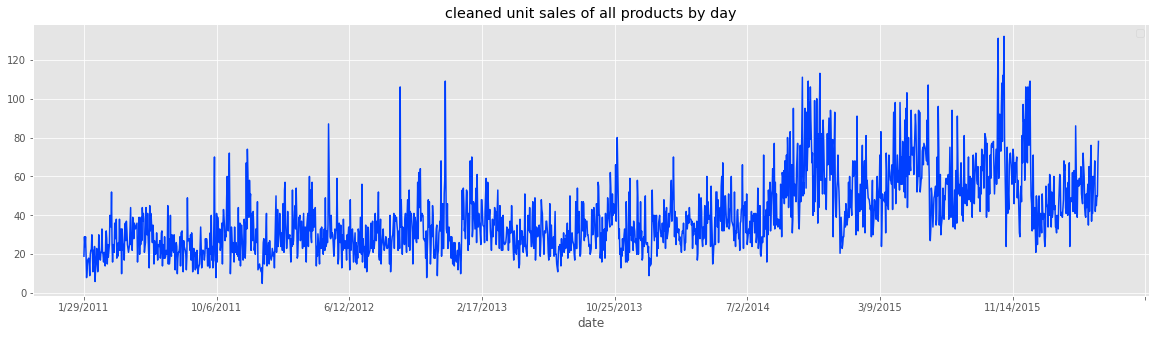

In [ ]:
y = all_data_merged.set_index('date')['sales']
places = all_data_merged.loc[~(all_data_merged['event_name_1'].isna()) | ~(all_data_merged['event_name_2'].isna())]['d']
change = list(all_data_merged.d.isin(list(places)))
for i in range(len(change)):
    if change[i] == True:
        y.iloc[i] = (y.iloc[i-1] + y.iloc[i+1]) / 2
y.plot(figsize=(20, 5),
          title='cleaned unit sales of all products by day')
plt.legend('')
plt.show()

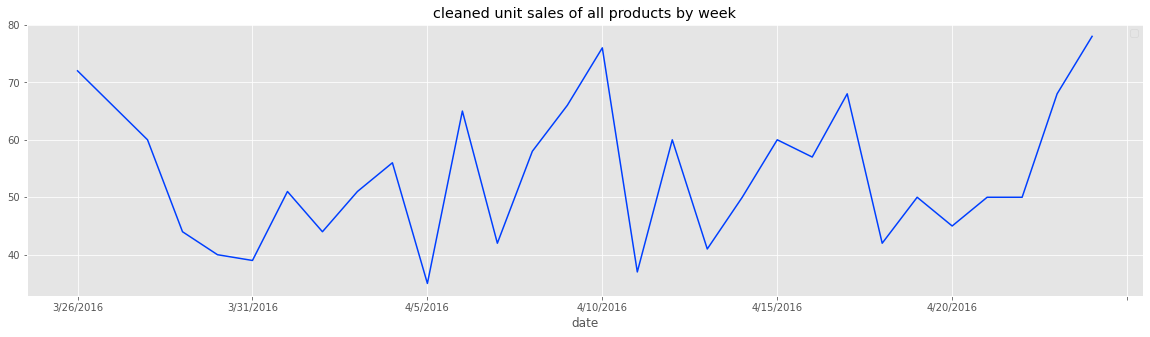

In [ ]:
y.iloc[-30:,].plot(figsize=(20, 5),
          title='cleaned unit sales of all products by week')
plt.legend('')
plt.show()

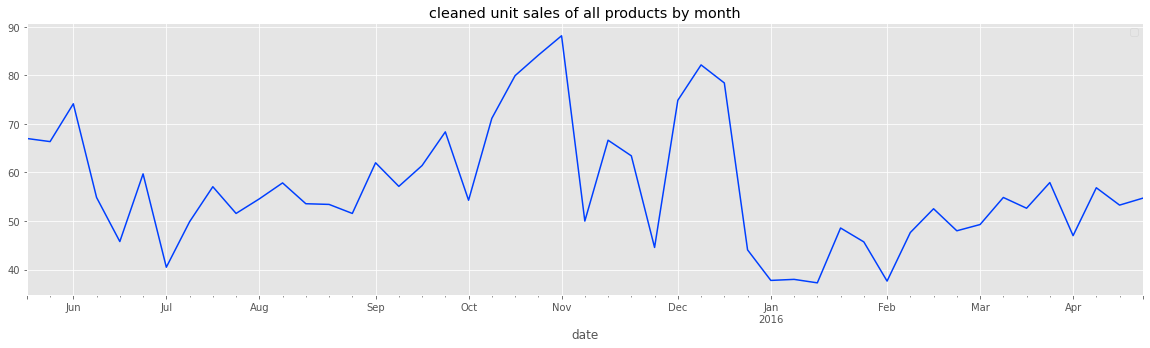

In [ ]:
y_month = y.reset_index()
y_month['date'] = pd.to_datetime(y_month['date'])
y_month = y_month.set_index('date')
y_month = y_month.resample('W').mean()

y_month.iloc[-49:,].plot(figsize=(20, 5),
          title='cleaned unit sales of all products by month')
plt.legend('')
plt.show()

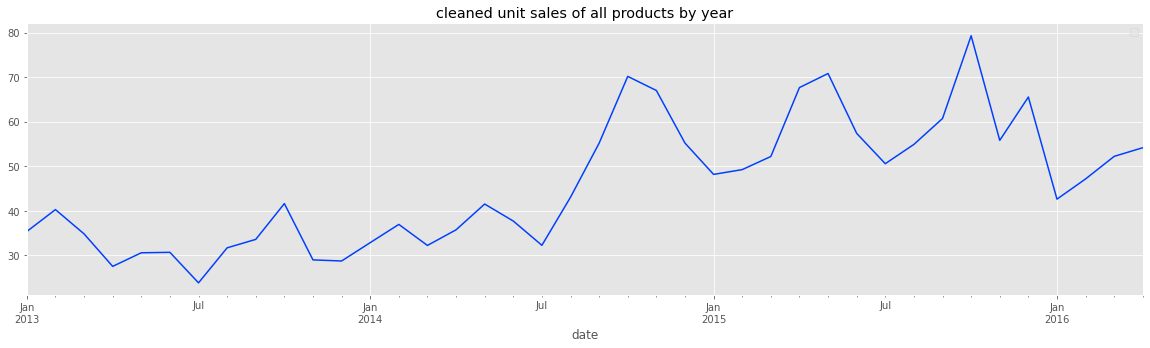

In [ ]:


y_year = y.reset_index()
y_year['date'] = pd.to_datetime(y_year['date'])
y_year = y_year.set_index('date')
y_year = y_year.resample('M').mean()

y_year.iloc[-40:,].plot(figsize=(20, 5),
          title='cleaned unit sales of all products by year')
plt.legend('')
plt.show()

In [ ]:
y_sales = y.reset_index().drop(['date'],axis=1)

#Time scale
predic1 = range(1913)

#Applying the Fourier series to the time scale
predic_annual_cos = list(map(lambda x: math.cos(2*math.pi*x/365), predic1))
predic_annual_sin = list(map(lambda x: math.sin(2*math.pi*x/365), predic1))

predic_month_cos = list(map(lambda x: math.cos(2*math.pi*x/30), predic1))
predic_month_sin = list(map(lambda x: math.sin(2*math.pi*x/30), predic1))

predic_week_cos = list(map(lambda x: math.cos(2*math.pi*x/7), predic1))
predic_week_sin = list(map(lambda x: math.sin(2*math.pi*x/7), predic1))

#assembling the regressors
reg = pd.DataFrame(list(zip(predic1, predic_annual_cos, predic_annual_sin, predic_month_cos, predic_month_sin, predic_week_cos, predic_week_sin)), 
               columns =['predic1', 'predic_annual_cos', 'predic_annual_sin', 'predic_month_cos', 'predic_month_sin', 'predic_week_cos', 'predic_week_sin']) 

#Model
model = LinearRegression().fit(reg, y_sales)

#The estimated parameters
r2 = model.score(reg, y_sales)
print('coefficient of determination:', r2)

coefficient of determination: 0.3799418354774409


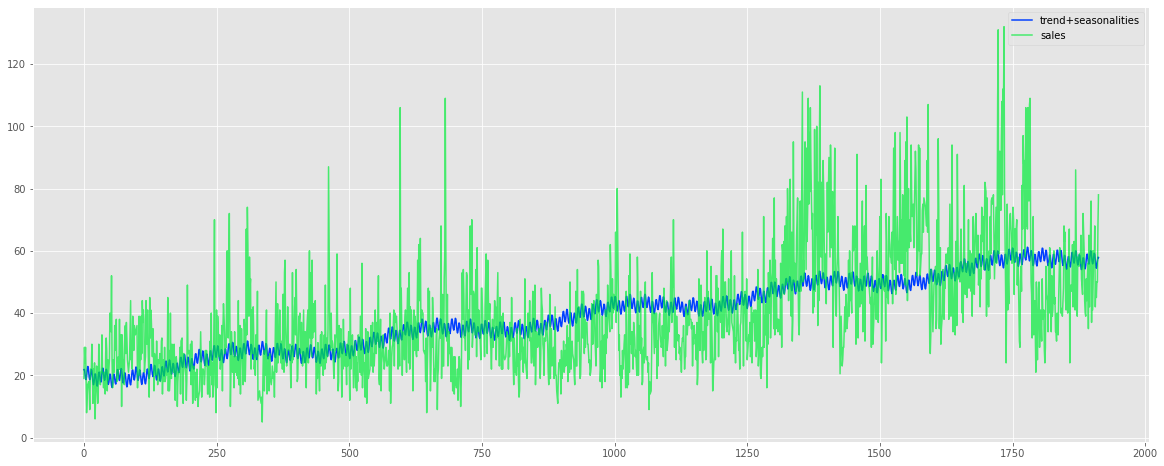

In [ ]:
trend = model.intercept_ + model.coef_[0][0]*np.array(predic1)
seas_annual = model.coef_[0][1]*np.array(predic_annual_cos) + model.coef_[0][2]*np.array(predic_annual_sin)
seas_month = model.coef_[0][3]*np.array(predic_month_cos) + model.coef_[0][4]*np.array(predic_month_sin)
seas_week = model.coef_[0][5]*np.array(predic_week_cos) + model.coef_[0][6]*np.array(predic_week_sin)

trend_seas = trend + seas_annual + seas_month + seas_week

ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
y_sales.plot(ax=ax,alpha=0.7)

In [ ]:

days = [col for col in sales.columns if "d_" in col]

In [ ]:
calendar = pd.read_csv('calendar_afcs2020.csv')
prices = pd.read_csv('sell_prices_afcs2020.csv')
sales = pd.read_csv('sales_train_validation_afcs2020.csv')
sub = pd.read_csv('sample_submission_afcs2020.csv')

In [ ]:

days = [c for c in sales.columns if 'd_' in c] # sales data columns
total_per_day = pd.DataFrame()
total_per_day['sales'] = sales[days].sum()
total_per_day['date'] = calendar.date[:1913].values
#total_per_day['date'] = pd.to_datetime(total_per_day['date'])
#total_per_day['weekday'] = total_per_day['date'].dt.day_name()
calendar['date'] = pd.to_datetime(calendar['date'])
total_per_day['date_short'] =  total_per_day['date'].str[5:]
total_per_day['date'] = pd.to_datetime(total_per_day['date'])
total_per_day['day'] = total_per_day.date.dt.day
total_per_day['month'] = total_per_day.date.dt.month_name()
total_per_day['weekday'] = total_per_day['date'].dt.day_name()
total_per_day['year'] = total_per_day.date.dt.year
# to have dates as x-axis labels in decomposition plots
total_per_day = total_per_day.set_index("date")




In [ ]:
total_per_day.tail()

,sales,date_short,day,month,weekday,year
date,,,,,,
2016-04-20,45,2016,20,April,Wednesday,2016
2016-04-21,50,2016,21,April,Thursday,2016
2016-04-22,50,2016,22,April,Friday,2016
2016-04-23,68,2016,23,April,Saturday,2016
2016-04-24,78,2016,24,April,Sunday,2016


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



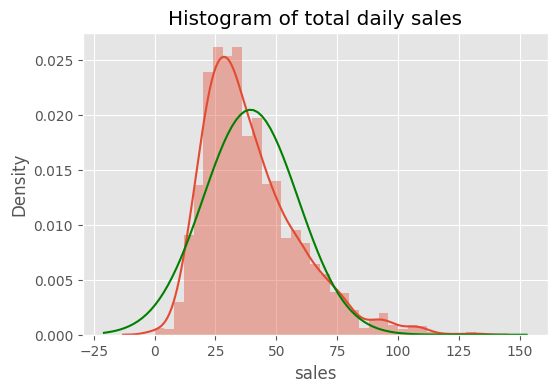

In [ ]:
                                              
ax = sns.distplot(total_per_day.sales)                                    
mu, std = stats.norm.fit(total_per_day.sales)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'g')
plt.title("Histogram of total daily sales")
plt.show()

In [ ]:


k2, p = stats.normaltest(total_per_day.sales)
alpha = 1e-3
print("Normality test:")
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Data is normally distributed")
else:
    print("Data is NOT normally distributed")



Normality test:
Data is normally distributed


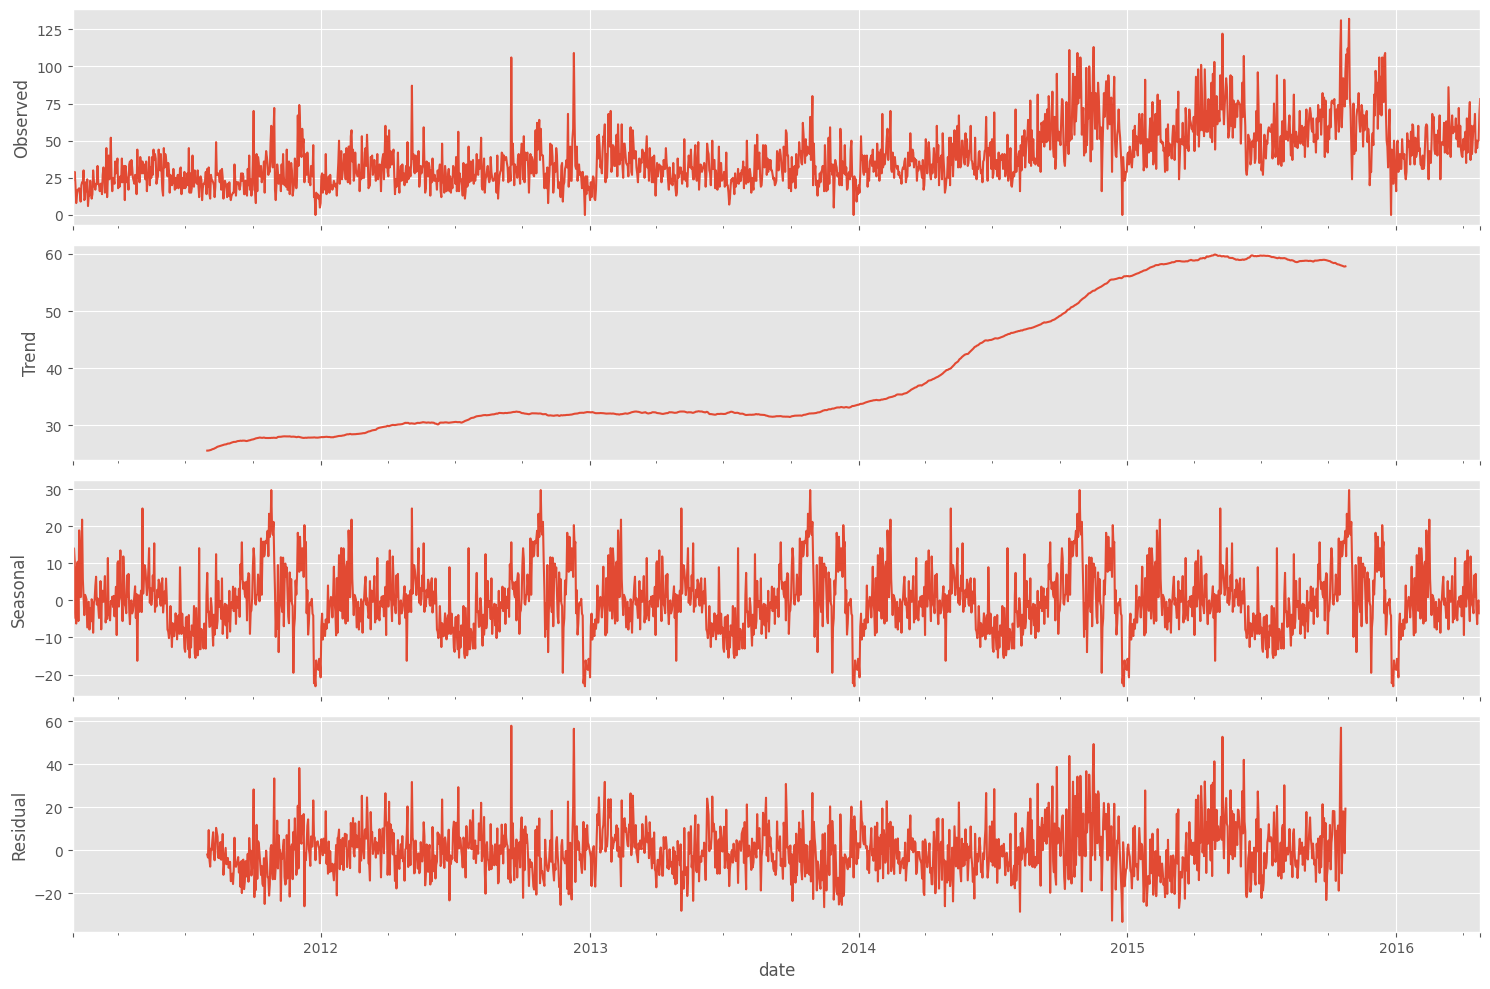

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# daily measurements, season repeats every year
decompfreq = 366
model = 'multiplicative'
mpl.rcParams['figure.figsize'] = (15, 10)
decomposition = seasonal_decompose(
    total_per_day['sales'],
    freq=decompfreq)
fig = decomposition.plot()

In [ ]:
def values_on_bars():
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), str(int(p.get_height())), 
        fontsize=12, ha='center', va='bottom')

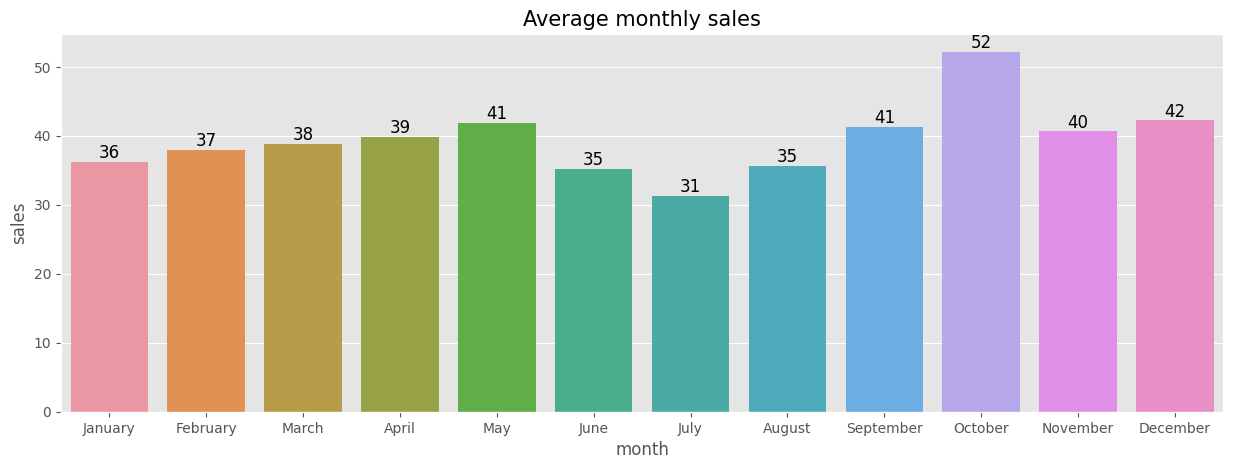

In [ ]:
mpl.rcParams['figure.figsize'] = (15, 5)
ax = sns.barplot(x='month',y='sales',data=total_per_day,ci=None)
values_on_bars()
plt.title("Average monthly sales",fontsize=15)
plt.show()

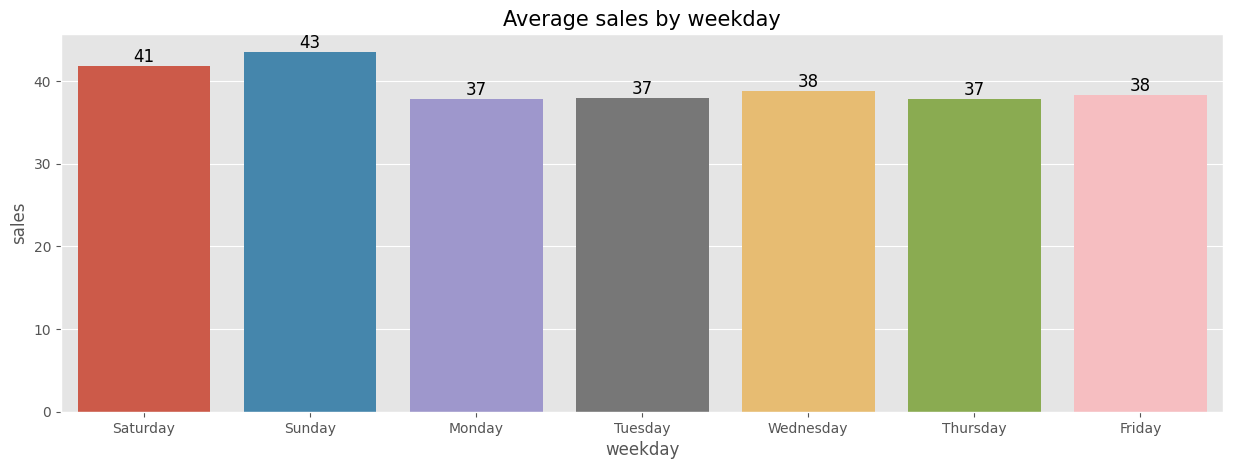

In [ ]:
mpl.rcParams['figure.figsize'] = (15, 5)
ax = sns.barplot(x='weekday',y='sales',data=total_per_day,ci=None)
values_on_bars()
plt.title("Average sales by weekday",fontsize=15)
plt.show()

In [ ]:
calendar_data = pd.read_csv('calendar_afcs2020.csv')
price_data = pd.read_csv('sell_prices_afcs2020.csv')
sales_data = pd.read_csv('sales_train_validation_afcs2020.csv')
submission_data = pd.read_csv('sample_submission_afcs2020.csv')

In [ ]:
price_data.tail()

,store_id,item_id,wm_yr_wk,sell_price,Category
32493,CA_3,HOBBIES_2_149,11617,0.970,HOBBIES
32494,CA_3,HOBBIES_2_149,11618,0.970,HOBBIES
32495,CA_3,HOBBIES_2_149,11619,0.970,HOBBIES
32496,CA_3,HOBBIES_2_149,11620,0.970,HOBBIES
32497,CA_3,HOBBIES_2_149,11621,0.970,HOBBIES


In [ ]:
ranges = [0,1,2,3,4,5,6,7,8,9,10]
price_data.groupby(pd.cut(price_data.sell_price, ranges)).count()

,store_id,item_id,wm_yr_wk,sell_price,Category
sell_price,,,,,
"(0, 1]",10465,10465,10465,10465,10465
"(1, 2]",3868,3868,3868,3868,3868
"(2, 3]",8862,8862,8862,8862,8862
"(3, 4]",2995,2995,2995,2995,2995
"(4, 5]",2989,2989,2989,2989,2989
"(5, 6]",1843,1843,1843,1843,1843
"(6, 7]",1002,1002,1002,1002,1002
"(7, 8]",219,219,219,219,219
"(8, 9]",0,0,0,0,0


Text(0.5, 1.0, 'Density plot of prices accross Hobbies')

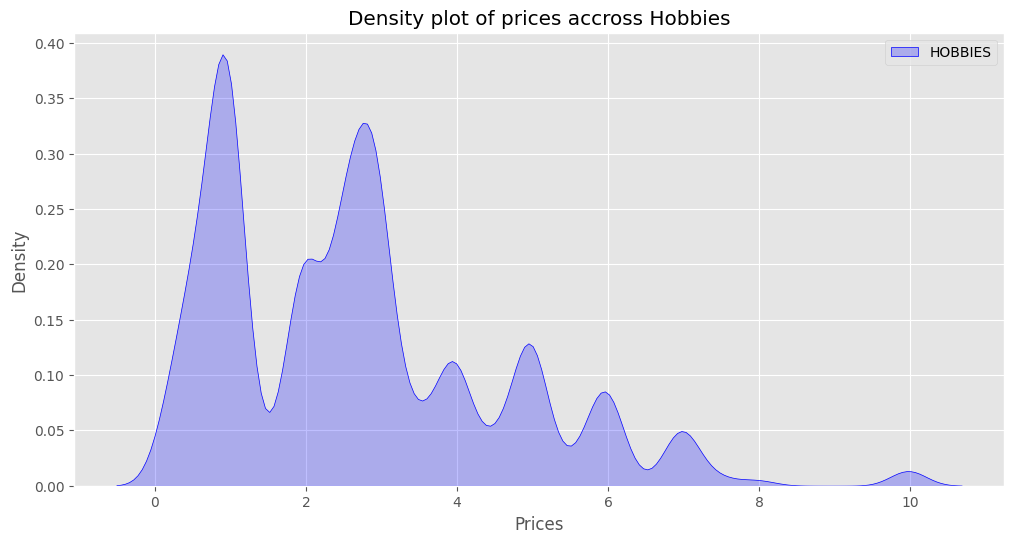

In [ ]:


price_data["Category"] = price_data["item_id"].str.split("_",expand = True)[0]
plt.figure(figsize=(12,6))
p1=sns.kdeplot(price_data[price_data['Category']=='HOBBIES']['sell_price'], shade=True, color="b")
plt.legend(labels=['HOBBIES'])

plt.xlabel("Prices")
plt.ylabel("Density")
plt.title("Density plot of prices accross Hobbies")



In [ ]:
item_store_prices = price_data.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]})
item_store_prices.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_prices.columns]                                         
item_store_prices["price_change"] = item_store_prices["sell_price_max"] - item_store_prices["sell_price_min"]
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]

In [ ]:
print("Items sorted by maximum price change over the years (top 10)")
item_store_prices_sorted.head(10)

Items sorted by maximum price change over the years (top 10)


,item_id,store_id,sell_price_max,sell_price_min,price_change,category
0,HOBBIES_2_114,CA_3,4.970,1.970,3.000,HOBBIES
1,HOBBIES_2_078,CA_3,7.670,4.970,2.700,HOBBIES
2,HOBBIES_2_134,CA_3,6.970,4.970,2.000,HOBBIES
3,HOBBIES_2_072,CA_3,7.970,5.970,2.000,HOBBIES
4,HOBBIES_2_009,CA_3,5.970,3.970,2.000,HOBBIES
5,HOBBIES_2_056,CA_3,3.500,1.940,1.560,HOBBIES
6,HOBBIES_2_149,CA_3,2.470,0.970,1.500,HOBBIES
7,HOBBIES_2_112,CA_3,2.470,0.970,1.500,HOBBIES
8,HOBBIES_2_113,CA_3,5.970,4.970,1.000,HOBBIES
9,HOBBIES_2_084,CA_3,6.970,5.970,1.000,HOBBIES


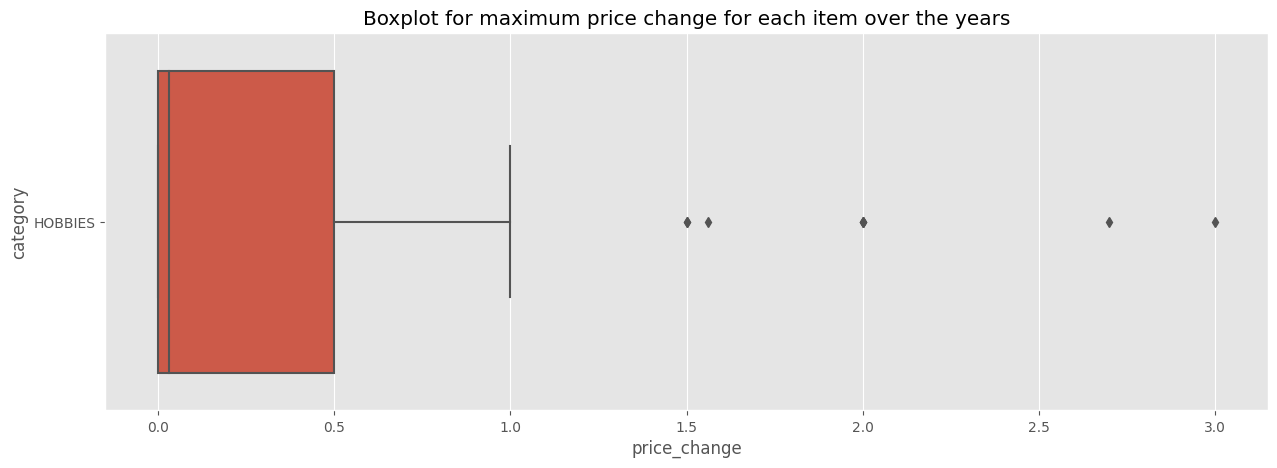

In [ ]:

sns.boxplot(x="price_change", y="category", data=item_store_prices_sorted)
title = plt.title("Boxplot for maximum price change for each item over the years")



In [ ]:
date_col = [c for c in sales.columns if 'd_' in c]

In [ ]:
import datetime

In [ ]:

base = datetime.datetime(2011,1,29)
sales_sum = pd.DataFrame(sales[date_col].sum(axis =0),columns = ["sales"])
sales_sum['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
sales_sum.set_index('datum', drop=True, inplace=True)
sales_sum.sort_index(inplace=True)



In [ ]:


print("Event days in 2012")
overall_sales_special[(overall_sales_special.year == 2012) & ((overall_sales_special.event_name_1.notnull()) | (overall_sales_special.event_name_2.notnull()))]



Event days in 2012


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sales
337,2012-01-01,11149,Sunday,2,1,2012,d_338,NewYear,National,NaN,NaN,1,8
343,2012-01-07,11150,Saturday,1,1,2012,d_344,OrthodoxChristmas,Religious,NaN,NaN,1,17
352,2012-01-16,11151,Monday,3,1,2012,d_353,MartinLutherKingDay,National,NaN,NaN,0,20
372,2012-02-05,11202,Sunday,2,2,2012,d_373,SuperBowl,Sporting,NaN,NaN,1,45
381,2012-02-14,11203,Tuesday,4,2,2012,d_382,ValentinesDay,Cultural,NaN,NaN,0,44
387,2012-02-20,11204,Monday,3,2,2012,d_388,PresidentsDay,National,NaN,NaN,0,26
389,2012-02-22,11204,Wednesday,5,2,2012,d_390,LentStart,Religious,NaN,NaN,0,34
396,2012-02-29,11205,Wednesday,5,2,2012,d_397,LentWeek2,Religious,NaN,NaN,0,25
404,2012-03-08,11206,Thursday,6,3,2012,d_405,Purim End,Religious,NaN,NaN,1,20
413,2012-03-17,11208,Saturday,1,3,2012,d_414,StPatricksDay,Cultural,NaN,NaN,0,28


In [ ]:
#Function for tagging events to the preceding weekend 
event_days_sales = overall_sales_special[((overall_sales_special.event_name_1.notnull()) | (overall_sales_special.event_name_2.notnull()))]
overall_sales_special["weekend_precede_event"] = np.nan

def update_weekend_precede_event(week_e,wday,e1,e2):
    e2 = '_' + e2 if type(e2) == str else ''
    drift = e1 + e2
    if wday == 1:
        overall_sales_special.loc[(overall_sales_special['wm_yr_wk']==week_e)&(overall_sales_special['wday']==1),"weekend_precede_event"] = drift
    else:
        overall_sales_special.loc[(overall_sales_special['wm_yr_wk']==week_e)&((overall_sales_special['wday']==1)|(overall_sales_special['wday']==2)),"weekend_precede_event"] = drift
        
_ = event_days_sales.apply(lambda row : update_weekend_precede_event(row['wm_yr_wk'],row['wday'],row['event_name_1'], row['event_name_2']),axis = 1)

In [ ]:


#adding event type column
events.columns = ["weekend_precede_event_type","weekend_precede_event"]
overall_sales_special = pd.merge(overall_sales_special,events,how= "left",on="weekend_precede_event")



In [ ]:
# Event names for each event type
events1 = calendar[['event_type_1','event_name_1',]]
events2 = calendar[['event_type_2','event_name_2',]]
events2.columns = ["event_type_1","event_name_1"]
events = pd.concat([events1,events2],ignore_index = True)
events = events.dropna().drop_duplicates()
events
events_dict = {k: g["event_name_1"].tolist() for k,g in events.groupby("event_type_1")}
print("Event Names across different Event Types")
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in events_dict.items()]))

Event Names across different Event Types


,Cultural,National,Religious,Sporting
0,ValentinesDay,PresidentsDay,LentStart,SuperBowl
1,StPatricksDay,MemorialDay,LentWeek2,NBAFinalsStart
2,Cinco De Mayo,IndependenceDay,Purim End,NBAFinalsEnd
3,Mother's day,LaborDay,OrthodoxEaster,NaN
4,Father's day,ColumbusDay,Pesach End,NaN
5,Halloween,VeteransDay,Ramadan starts,NaN
6,Easter,Thanksgiving,Eid al-Fitr,NaN
7,NaN,Christmas,EidAlAdha,NaN
8,NaN,NewYear,Chanukah End,NaN
9,NaN,MartinLutherKingDay,OrthodoxChristmas,NaN


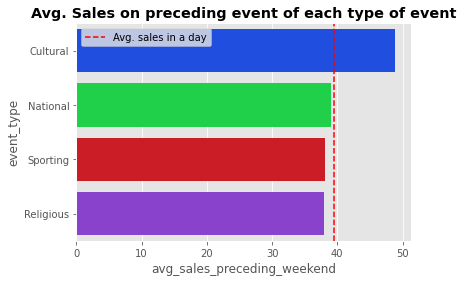

In [ ]:


#Calculating sales impact of each event on preceding weekend
event_type_impact = overall_sales_special.groupby(['weekend_precede_event_type'])['sales'].mean().reset_index()
event_type_impact = event_type_impact.sort_values("sales",ascending = False)
event_type_impact.columns = ["event_type","avg_sales_preceding_weekend"]
#Plotting a bar graph of avg. sales on the weekend days before the event to see the impact
chart = sns.barplot(y= "event_type", x='avg_sales_preceding_weekend', data=event_type_impact)
chart.axvline(sales_sum.sales.mean(),label = "Avg. sales in a day",c='red', linestyle='dashed')
plt.title("Avg. Sales on preceding event of each type of event", fontweight ="bold")
leg = plt.legend()



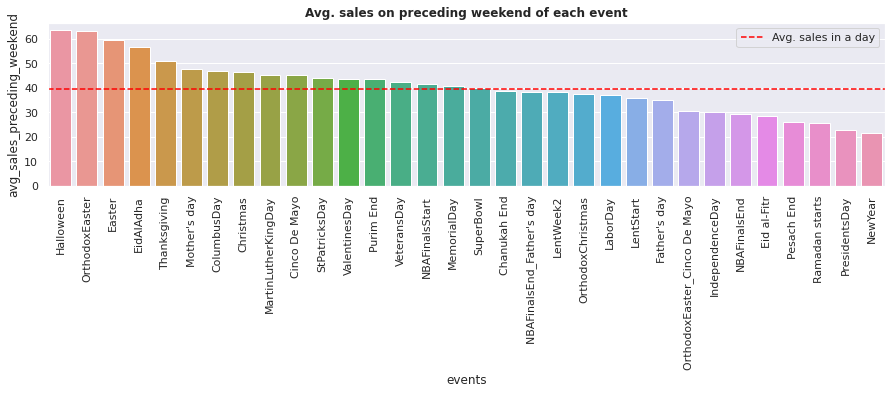

In [ ]:
#Calculating sales impact of each event on preceding weekend
event_impact = overall_sales_special.groupby(['weekend_precede_event'])['sales'].mean().reset_index()
event_impact = event_impact.sort_values("sales",ascending = False)
event_impact.columns = ["events","avg_sales_preceding_weekend"]
# Plotting a bar graph of avg. sales on the weekend days before the event to see the impact
sns.set(rc={'figure.figsize':(15,3)})
chart = sns.barplot(x= "events", y='avg_sales_preceding_weekend', data=event_impact)
chart.axhline(sales_sum.sales.mean(),label = "Avg. sales in a day",c='red', linestyle='dashed')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Avg. sales on preceding weekend of each event",fontweight = "bold")
leg = plt.legend()

In [213]:
lol = stv.loc[stv['id'] == 'HOBBIES_2_028_CA_3_validation'][d_cols]

In [214]:
x = lol.iloc[:,-28:]
x = x.set_axis(['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28'], axis=1, inplace=False)

x.insert(0,'id',"HOBBIES_2_024_CA_3_validation")
x.insert(1,'method',"actual_sales_last_28_days")
x_s = x

In [215]:
prophet = pd.read_csv("prophet.csv")
prophet.insert(1,'method',"prophet")
prophet_s = prophet[prophet['id'] == 'HOBBIES_2_028_CA_3_validation']


In [220]:
mean = predictions
mean.insert(1,'method',"mean")
mean_s=mean[mean['id'] == 'HOBBIES_2_028_CA_3_validation']

In [221]:
lgbm = pd.read_csv("lgbm.csv")
lgbm.insert(1,'method',"lgbm")
lgbm_s = lgbm[lgbm['id'] == 'HOBBIES_2_028_CA_3_validation']

In [254]:
es = pd.read_csv("es.csv")
es.insert(1,'method',"exponential smoothing")
es_s = es[es['id'] == 'HOBBIES_2_028_CA_3_validation']

In [255]:
frames = [x_s, prophet_s, mean_s,lgbm_s,es_s]
result = pd.concat(frames)


In [256]:
result

,id,method,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,E28,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
27,HOBBIES_2_024_CA_3_validation,actual_sales_last_28_days,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,2.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,2.000,1.000,1.000,3.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
27,HOBBIES_2_028_CA_3_validation,prophet,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.755,0.792,0.816,0.779,0.680,0.032,0.107,0.538,0.573,0.595,0.361,0.456,0.572,0.086,0.485,0.519,0.540,0.500,0.398,0.513,0.434,0.423,0.457,0.477,0.436,0.334,0.448,0.369
27,HOBBIES_2_028_CA_3_validation,mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607
27,HOBBIES_2_028_CA_3_validation,lgbm,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.381,0.283,0.441,0.387,0.299,0.385,0.484,0.409,0.345,0.538,0.516,0.459,0.573,0.696,0.642,0.593,0.796,0.778,0.719,0.825,0.935,0.861,0.787,0.959,0.906,0.809,0.874,0.940
27,HOBBIES_2_028_CA_3_validation,exponential smoothing,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958


In [257]:
reult1 = result.groupby("method",dropna=False)['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28','F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [258]:
reult1.head()

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,E28,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
method,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
actual_sales_last_28_days,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,2.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,2.000,1.000,1.000,3.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
exponential smoothing,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958,0.958
lgbm,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.381,0.283,0.441,0.387,0.299,0.385,0.484,0.409,0.345,0.538,0.516,0.459,0.573,0.696,0.642,0.593,0.796,0.778,0.719,0.825,0.935,0.861,0.787,0.959,0.906,0.809,0.874,0.940
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607,0.607
prophet,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.755,0.792,0.816,0.779,0.680,0.032,0.107,0.538,0.573,0.595,0.361,0.456,0.572,0.086,0.485,0.519,0.540,0.500,0.398,0.513,0.434,0.423,0.457,0.477,0.436,0.334,0.448,0.369


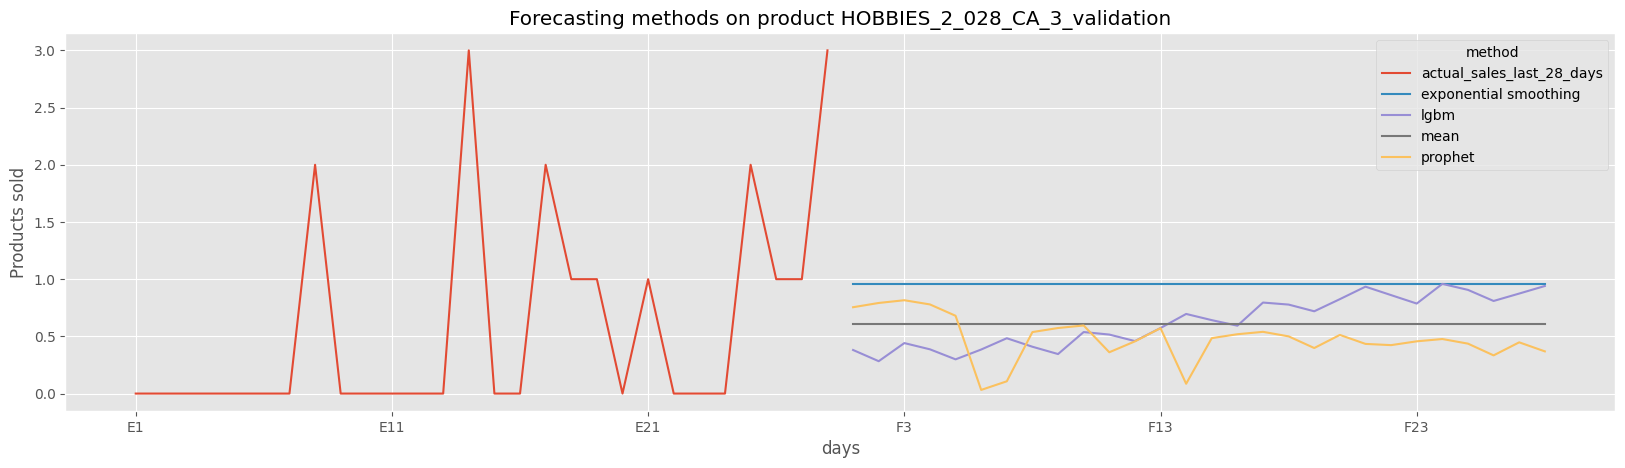

In [267]:
reult1.T.plot(figsize=(20, 5),title='Forecasting methods on product HOBBIES_2_028_CA_3_validation')
plt.xlabel('days')
plt.ylabel('Products sold')
plt.show()

In [ ]:
calendar_df = pd.read_csv('calendar_afcs2020.csv')
price_data = pd.read_csv('sell_prices_afcs2020.csv')
train_sales = pd.read_csv('sales_train_validation_afcs2020.csv')
submission_file = pd.read_csv('sample_submission_afcs2020.csv')

In [ ]:
series_data = train_sales[time_series_columns].values

In [ ]:


forecast = pd.DataFrame(series_data[:, -28:]).mean(axis=1)
forecast = pd.concat([forecast] * 28, axis=1)
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast.shape



(149, 28)

In [217]:
validation_ids = train_sales['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]


ids = validation_ids


predictions = pd.DataFrame(ids, columns=['id'])


In [218]:
predictions = pd.concat([predictions, forecast], axis=1)

In [219]:
predictions.shape

(149, 29)

In [ ]:
predictions.head(28)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_2_001_CA_3_validation,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107,0.107
1,HOBBIES_2_002_CA_3_validation,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179,0.179
2,HOBBIES_2_003_CA_3_validation,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571,0.571
3,HOBBIES_2_004_CA_3_validation,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286,0.286
4,HOBBIES_2_005_CA_3_validation,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143,0.143


In [ ]:


forecast = pd.DataFrame(series_data[:, -28:]).mean(axis=1)
forecast = pd.concat([forecast] * 28, axis=1)
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast.head()

